In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import pickle

In [2]:
df = pd.read_csv("./data/data.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Creating Target Variable
print(df.shape)
y = df.iloc[:,-1].replace({'Y': 1,'N': 0}).astype(int)
df = df.drop(['Loan_Status', 'Loan_ID'], axis=1)

(614, 13)


In [5]:
y.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [4]:
df.shape

(614, 11)

In [5]:
# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(491, 11)
(123, 11)
(491,)
(123,)


#### Split features based on null replacement

In [6]:
cat_feats = ['Self_Employed', 'Dependents', 'Gender','Married','Education', 'Property_Area']
num_feats = ['ApplicantIncome', 'CoapplicantIncome','Credit_History', 'LoanAmount', 'Loan_Amount_Term']

In [7]:
from sklearn.preprocessing import FunctionTransformer

def total_income(data):
    data['TotalIncome'] = (data['ApplicantIncome'] + data['CoapplicantIncome'])
    return data['TotalIncome']

# Using own function in Pipeline
def numFeatNull(data):
    # Replace null values
    data.fillna({'Credit_History': 0,
            'LoanAmount': data['LoanAmount'].median(),
            'Loan_Amount_Term': data['Loan_Amount_Term'].median(),}, inplace=True)
    
    # Add new column TotalIncome
    data['TotalIncome'] = (data['ApplicantIncome'] + data['CoapplicantIncome']) #.apply(np.log)
    #data.loc[:, 'TotalIncome'] = (data['ApplicantIncome'] + data['CoapplicantIncome'])
    
    # Log
    #data['LoanAmount'] = data['LoanAmount'].apply(np.log)
    
    return data[num_feats]

def catFeatNull(data):
    data.fillna({'Self_Employed': 'Not_specified',
                'Dependents': df['Dependents'].mode()[0],
                'Gender': 'Not_specified',
                'Married': 'No'}, inplace=True)
    return data[cat_feats]

class ToDenseTransformer():

    # here you define the operation it should perform
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    # just return self
    def fit(self, X, y=None, **fit_params):
        return self

In [8]:
clean_num = FunctionTransformer(numFeatNull, validate=False)
clean_cat = FunctionTransformer(catFeatNull, validate=False)

In [9]:
# one-hot encoder
enc = OneHotEncoder(handle_unknown='ignore')

In [10]:
sc = StandardScaler()

In [11]:
# Create a svm Classifier
clf_svc = svm.SVC() 

In [15]:
num_pipeline = Pipeline([
    ('cleanNum', clean_num),
    ('scaler', sc)
])

cat_pipeline = Pipeline([
    ('cleanCat', clean_cat),
    ('oneHotEnc', enc),
    ('to_dense',ToDenseTransformer()),
    #('scaler', sc)
])


In [13]:
numeric_transformer = Pipeline(steps=[
    ('cleanNum', clean_num),
    ('scaler', sc)])

categorical_transformer = Pipeline(steps=[
    ('cleanCat', clean_cat),
    ('oneHotEnc', enc),
    ('to_dense',ToDenseTransformer())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_feats)])

In [14]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', svm.SVC())])

In [15]:
clf.fit(X_train, y_train)

#print("model score: %.3f" % clf.score(X_test, y_test))
#y_pred = clf.predict(X_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('cleanNum',
                                                                   FunctionTransformer(func=<function numFeatNull at 0x7fb303c5a940>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'Credit_History',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term']),
                                                 ('cat',
                                                  Pipeline(steps=[('cleanCat',
                                             

In [16]:
all_features = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [17]:
n_estimators=100
criterion='mse'
max_depth=None
n_jobs=-1
# fit model no training data
xgb = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth)


In [18]:
main_pipeline = Pipeline([
    ("features", all_features),
    ("xgb", xgb)
])

In [16]:
clf_svc.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [20]:
# set up our parameters grid
param_grid = {    "xgb__n_estimators":[10, 100, 150, 200],
                  "xgb__gamma":[0.001, 0.01, 0.1, 1, 10, 100],
                  "xgb__learning_rate": [0.01, 0.1, 1, 10]
             }

# create a Grid Search object
grid_search = GridSearchCV(main_pipeline, param_grid, n_jobs = -1, verbose=10, refit=True)

# fit the model and tune parameters
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

[12:40:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('cleanNum',
                                                                                         FunctionTransformer(func=<function numFeatNull at 0x7ff3cf45ac10>)),
                                                                                        ('scaler',
                                                                                         StandardScaler())])),
                                                                       ('cat_pipeline',
                                                                        Pipeline(steps=[('cleanCat',
                                                                                         FunctionTransformer(func=<function catFeatNull at 0x7ff3cf45ab80>)),
                                            

In [ ]:
# need to make matrices dense because PCA does not work with sparse vectors.
pipeline = Pipeline([
    ('to_dense',ToDenseTransformer()),
    ('pca',PCA()),
    ('clf',DecisionTreeClassifier())
])

pipeline.fit(sparse_data_matrix,target)
pipeline.predict(sparse_data_matrix)

In [21]:
print(grid_search.best_params_)

{'xgb__gamma': 10, 'xgb__learning_rate': 0.01, 'xgb__n_estimators': 10}


In [22]:
#grid_search.predict_proba(X_test)
y_pred = grid_search.predict(X_test)

/Users/jandas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-7-f67eb498db0f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalIncome'] = (data['ApplicantIncome'] + data['CoapplicantIncome']) #.apply(np.log)
/Users/jandas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [19]:
#y_pred = main_pipeline.transform(X_test)

AttributeError: 'SVC' object has no attribute 'transform'

In [23]:
print('Final score is: ', grid_search.score(X_test, y_test))

Final score is:  0.8130081300813008


/Users/jandas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-7-f67eb498db0f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalIncome'] = (data['ApplicantIncome'] + data['CoapplicantIncome']) #.apply(np.log)
/Users/jandas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
# model evaluation using confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix # Diagonal values represent accurate predictions, non diagonal elements are inaccurate predictions.

array([[32, 14],
       [ 9, 68]])

Text(0.5, 257.44, 'Predicted label')

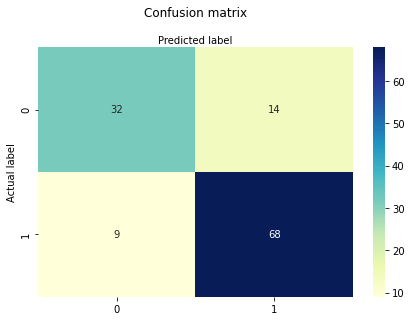

In [26]:
# Visualizing Confusion Matrix using Heatmap
class_names=['0', '1'] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create hetmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [27]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8130081300813008


In [28]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

Precision: 0.8292682926829268


In [29]:
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Recall: 0.8831168831168831


In [30]:
y_test.value_counts()

1    77
0    46
Name: Loan_Status, dtype: int64

In [31]:
np.unique(y_pred)

array([0, 1])

Area under the ROC curve : 0.789385


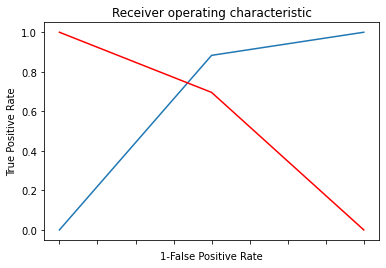

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})


optCutOff = roc.loc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])
plt.show()

Try paramater grid search to improve the results

In [27]:
optCutOff

,fpr,tpr,1-fpr,tf,thresholds
1,0.351351,0.860465,0.648649,0.211816,1


In [34]:
clf.fit(X_train, y_train)

In [64]:
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.732


In [38]:
pickle.dump( grid_search, open( "./models/model_grid_search.p", "wb" ) )

In [122]:
import pickle
pickle.dump( clf, open( "./models/model.p", "wb" ) )

In [19]:
X_test.shape

(123, 11)

In [116]:
# Not approved
json_data = {'Gender': 'Male',
 'Married': 'Yes',
 'Dependents': '0',
 'Education': 'Graduate',
 'Self_Employed': 'No',
 'ApplicantIncome': 3899,
 'CoapplicantIncome': 0,
 'LoanAmount': 80000,
 'Loan_Amount_Term': 360,
 'Credit_History': 0,
 'Property_Area': 'Urban'
 }

In [128]:
# Approved
json_data = {'Gender': 'Male',
 'Married': 'Yes',
 'Dependents': '0',
 'Education': 'Graduate',
 'Self_Employed': 'No',
 'ApplicantIncome': 3899,
 'CoapplicantIncome': 2397,
 'LoanAmount': 800,
 'Loan_Amount_Term': 360,
 'Credit_History': 1,
 'Property_Area': 'Urban'
}

In [148]:
type(json_data)

dict

In [144]:
json_data = {"Gender": "Male", "Married": "Yes", "Dependents": "0", "Education": "Graduate", "Self_Employed": "No", "ApplicantIncome": 3899, "CoapplicantIncome": 0, "LoanAmount": 80000, "Loan_Amount_Term": 360, "Credit_History": 1, "Property_Area": "Urban"}

In [145]:
import requests
#URL = "http://127.0.0.1:5000/scoring"
URL = "http://ec2-18-117-82-160.us-east-2.compute.amazonaws.com:5555/scoring"
# sending get request and saving the response as response object 
r = requests.post(url = URL, json = json_data) 

In [146]:
print(r.json())

[0]


In [140]:
df = pd.DataFrame(json_data.values(), index=json_data.keys()).transpose()

In [109]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,0,Graduate,No,3899,0,80000,360,0,Urban


In [110]:
res = clf.predict(df)

In [111]:
res

array([0])

In [112]:
print(res[0])

0


In [63]:
if res[0]:
    print("Your Loan has been Approved")
else: print("You are not elegible for this Loan")

You do not meet all the requirements for the Loan


# Test from Postman

#### Not approved
{"Gender": "Male",
 "Married": "Yes",
 "Dependents": "0",
 "Education": "Graduate",
 "Self_Employed": "No",
 "ApplicantIncome": 3899,
 "CoapplicantIncome": 0,
 "LoanAmount": 80000,
 "Loan_Amount_Term": 360,
 "Credit_History": 0,
 "Property_Area": "Urban"
 }

In [123]:
#### Approved
{"Gender": "Male",
 "Married": "Yes",
 "Dependents": "0",
 "Education": "Graduate",
 "Self_Employed": "No",
 "ApplicantIncome": 3899,
 "CoapplicantIncome": 2397,
 "LoanAmount": 800,
 "Loan_Amount_Term": 360,
 "Credit_History": 1,
 "Property_Area": "Urban"
}

In [ ]:
{"Gender": "Male",
 "Married": "Yes",
 "Dependents": "0",
 "Education": "Graduate",
 "Self_Employed": "No",
 "ApplicantIncome": 3899,
 "CoapplicantIncome": 0,
 "LoanAmount": 80000,
 "Loan_Amount_Term": 360,
 "Credit_History": 0,
 "Property_Area": "Urban"
 }

In [147]:
X_test.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')